# IRFs and sensitivity pyirf

**WARNING**

This is still a work-in-progress, it will evolve with the pipeline comparisons and converge with ctaplot+cta-benchmarks.

**IMPORTANT**

Soon this will be supersided by new results using [pyirf](https://github.com/cta-observatory/pyirf) and ctaplot metrics.

**Author(s):**
    
- Dr. Michele Peresano (CEA-Saclay/IRFU/DAp/LEPCHE), 2020
based on previous work by J. Lefacheur.
- Alice Donini (INFN Sezione di Trieste and Universita degli Studi di Udine), 2020
- Gaia Verna (Aix Marseille Univ, CNRS/IN2P3, CPPM, Marseille, France), 2020

based on [pyirf](https://github.com/cta-observatory/pyirf/blob/master/docs/notebooks/) 

**Description:**

This notebook contains DL3 and benchmarks for the _protopipe_ pipeline. 

Note that:
    - a more general set of benchmarks is being defined in cta-benchmarks/ctaplot,
    - follow [this](https://www.overleaf.com/16933164ghbhvjtchknf) document by adding new benchmarks or proposing new ones.

**Requirements:**

To run this notebook you will need a set of DL2 files produced on the grid with protopipe script _make_performance_pyirf_EventDisplay.py_

The MC production to be used and the appropriate set of files to use for this notebook can be found [here](https://forge.in2p3.fr/projects/step-by-step-reference-mars-analysis/wiki#The-MC-sample ).

The data format required to run the notebook is the current one used by _protopipe_ .

**Development and testing:**  

For the moment this notebook is optimized to work only on files produced from LSTCam + NectarCam telescope configurations.  
As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.  
The execution of this notebook is not currently automatic, it must be done locally by the user - preferably _before_ pushing a pull-request.  
**IMPORTANT:** Please, if you wish to contribute to this notebook, before pushing anything to your branch (better even before opening the PR) clear all the output and remove any local directory paths that you used for testing (leave empty strings).

**TODO:**  
* update everything...

## Table of contents

* [Optimized cuts](#Optimized-cuts)
    - [Direction cut](#Direction-cut)
* [Differential sensitivity from cuts optimization](#Differential-sensitivity-from-cuts-optimization)
* [IRFs](#IRFs)
    - [Effective area](#Effective-area)
    - [Point Spread Function](#Point-Spread-Function)
        + [Angular resolution](#Angular-resolution)
    - [Energy dispersion](#Energy-dispersion)
        + [Energy resolution](#Energy-resolution)
    - [Background rate](#Background-rate)

## Imports

In [1]:
import os

import pyirf
import numpy as np
from astropy.io import fits
import uproot4 as uproot
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.table import QTable, Table, Column
from matplotlib.ticker import ScalarFormatter

from pyirf.binning import bin_center
from pyirf.utils import cone_solid_angle

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

## Input data

In [2]:
#Path("./plots_DL3").mkdir(parents=True, exist_ok=True)
protopipe_file = './irf_tail_Time50.00h/pyirf_protopipe.fits.gz'

# Performance calculated with pyirf from ED DL2 files
ED_pyirf_file = 'reference_data/aswg/point-like/LaPalma_20_South_EventDisplay/EventDisplay_pyirf_North_20deg_S_onaxis_50h.fits.gz'

### Load EventDisplay North perf

In [3]:
# Path of EventDisplay IRF data in the user's local setup
# Please, empty the indir_EventDisplay variable before pushing to the repo
indir = "./reference_data/aswg/point-like/LaPalma_20_South_EventDisplay/"
irf_file_event_display = "DESY.d20191030.V2.ID0NIM2LST3MST3SST3SCMST3.prod3b-LaPalma-20degt05b-LL.Nb.3AL4-BN15.180000s.root"

irf_eventdisplay = uproot.open(os.path.join(indir, irf_file_event_display))

### Load Requirements

In [4]:
indir = './reference_data/requirements/'

site = 'North'
obs_time = '50h'

# Full array
infiles = dict(sens=f'/{site}-{obs_time}.dat') # 30 min
requirements = dict()
for key in infiles.keys():
    requirements[key] = Table.read(indir + infiles[key], format='ascii')
requirements['sens'].add_column(Column(data=(10**requirements['sens']['col1']), name='ENERGY'))
requirements['sens'].add_column(Column(data=requirements['sens']['col2'], name='SENSITIVITY'))

## Optimized cuts

### Direction cut

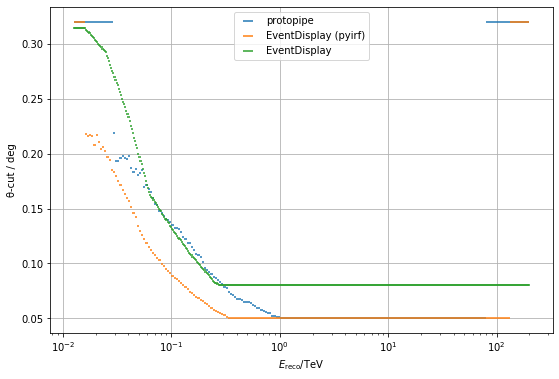

In [5]:
# protopipe
rad_max = QTable.read(protopipe_file, hdu='RAD_MAX')[0]
plt.errorbar(
    0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])[1:-1].to_value(u.TeV),
    rad_max['RAD_MAX'].T[1:-1, 0].to_value(u.deg),
    xerr=0.5 * (rad_max['ENERG_HI'] - rad_max['ENERG_LO'])[1:-1].to_value(u.TeV),
    ls='',
    label='protopipe',
)

# ED (pyirf)
rad_max = QTable.read(ED_pyirf_file, hdu='RAD_MAX')[0]
plt.errorbar(
    0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])[1:-1].to_value(u.TeV),
    rad_max['RAD_MAX'].T[1:-1, 0].to_value(u.deg),
    xerr=0.5 * (rad_max['ENERG_HI'] - rad_max['ENERG_LO'])[1:-1].to_value(u.TeV),
    ls='',
    label='EventDisplay (pyirf)',
)

# ED
theta_cut_ed, edges = irf_eventdisplay['ThetaCut;1'].to_numpy()
plt.errorbar(
    bin_center(10**edges),
    theta_cut_ed,
    xerr=np.diff(10**edges),
    ls='',
    label='EventDisplay',
)

plt.legend()
plt.ylabel('θ-cut / deg')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')
plt.grid()

None # to remove clutter by mpl objects

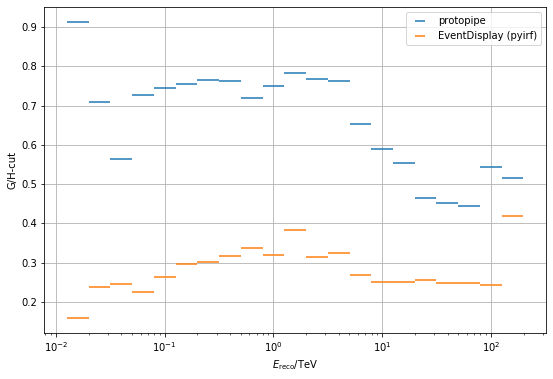

In [6]:
# protopipe
gh_cut = QTable.read(protopipe_file, hdu='GH_CUTS')[1:-1]
plt.errorbar(
    0.5 * (gh_cut['low'] + gh_cut['high']).to_value(u.TeV),
    gh_cut['cut'],
    xerr=0.5 * (gh_cut['high'] - gh_cut['low']).to_value(u.TeV),
    ls='',
    label='protopipe',
)

#  ED (pyirf)
gh_cut = QTable.read(ED_pyirf_file, hdu='GH_CUTS')[1:-1]
plt.errorbar(
    0.5 * (gh_cut['low'] + gh_cut['high']).to_value(u.TeV),
    gh_cut['cut'],
    xerr=0.5 * (gh_cut['high'] - gh_cut['low']).to_value(u.TeV),
    ls='',
    label='EventDisplay (pyirf)',
)


plt.legend()
plt.ylabel('G/H-cut')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')
plt.grid()

None # to remove clutter by mpl objects

## Differential sensitivity from cuts optimization

In [8]:
# [1:-1] removes under/overflow bins
sensitivity_protopipe = QTable.read(protopipe_file, hdu='SENSITIVITY')[1:-1]
sensitivity_ED_pyirf = QTable.read(ED_pyirf_file, hdu='SENSITIVITY')[1:-1]

# make it print nice
sensitivity_protopipe['reco_energy_low'].info.format = '.3g'
sensitivity_protopipe['reco_energy_high'].info.format = '.3g'
sensitivity_protopipe['reco_energy_center'].info.format = '.3g'
sensitivity_protopipe['relative_sensitivity'].info.format = '.2g'
sensitivity_protopipe['flux_sensitivity'].info.format = '.3g'

for k in filter(lambda k: k.startswith('n_'), sensitivity_protopipe.colnames):
    sensitivity_protopipe[k].info.format = '.1f'

sensitivity_protopipe

reco_energy_low,reco_energy_high,reco_energy_center,n_signal,n_signal_weighted,n_background,n_background_weighted,significance,relative_sensitivity,flux_sensitivity
TeV,TeV,TeV,,,,,,,1 / (cm2 s TeV)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0126,0.02,0.0163,nan,nan,0.0,0.0,nan,inf,inf
0.02,0.0316,0.0258,8.1,10.0,0.0,0.0,5.986250026900072,0.19,7.77e-08
0.0316,0.0501,0.0409,487.9,490.3,62.1,39114.8,4.999999999999659,0.034,4.12e-09
0.0501,0.0794,0.0648,578.5,436.1,102.9,30858.0,4.999999999999034,0.015,5.62e-10
0.0794,0.126,0.103,813.6,452.8,202.6,33302.5,5.000000000000455,0.0076,8.4e-11
0.126,0.2,0.163,740.1,309.5,161.2,15373.2,5.000000000000426,0.0059,1.94e-11
0.2,0.316,0.258,368.9,114.2,60.5,1959.1,5.000000000009874,0.0044,4.31e-12
0.316,0.501,0.409,271.6,62.8,29.3,542.7,5.000000000356103,0.0039,1.15e-12


## Protopipe Sensitivity

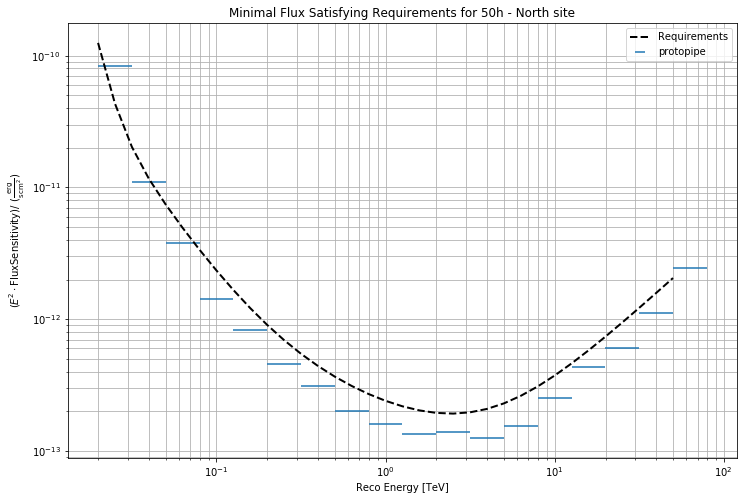

In [9]:
plt.figure(figsize=(12,8))

unit = u.Unit('erg cm-2 s-1')

# protopipe
e = sensitivity_protopipe['reco_energy_center']
w = (sensitivity_protopipe['reco_energy_high'] - sensitivity_protopipe['reco_energy_low'])
s = (e**2 * sensitivity_protopipe['flux_sensitivity'])

plt.errorbar(
    e.to_value(u.TeV),
    s.to_value(unit),
    xerr=w.to_value(u.TeV) / 2,
    ls='',
    label='protopipe'
)

# Add requirements
plt.plot(requirements['sens']['ENERGY'], 
         requirements['sens']['SENSITIVITY'], 
         color='black', 
         ls='--', 
         lw=2, 
         label='Requirements'
)

# Style settings
plt.title(f'Minimal Flux Satisfying Requirements for {obs_time} - {site} site')
plt.xscale("log")
plt.yscale("log")
plt.ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})")
plt.xlabel("Reco Energy [TeV]")

plt.grid(which="both")
plt.legend()


None # to remove clutter by mpl objects


## Sensitivity comparison

<Figure size 864x576 with 0 Axes>

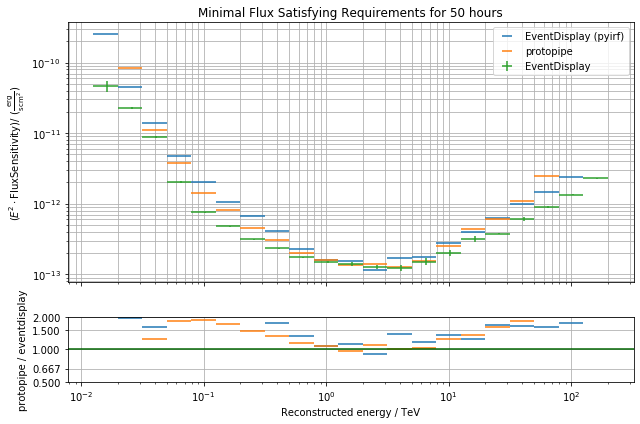

In [10]:
plt.figure(figsize=(12,8))
fig, (ax_sens, ax_ratio) = plt.subplots(
    2, 1,
    gridspec_kw={'height_ratios': [4, 1]},
    sharex=True,
)
unit = u.Unit('erg cm-2 s-1')

# ED (pyirf)
e = sensitivity_ED_pyirf['reco_energy_center']
w = (sensitivity_ED_pyirf['reco_energy_high'] - sensitivity_ED_pyirf['reco_energy_low'])
s_ED = (e**2 * sensitivity_ED_pyirf['flux_sensitivity'])
ax_sens.errorbar(
    e.to_value(u.TeV),
    s_ED.to_value(unit),
    xerr=w.to_value(u.TeV) / 2,
    ls='',
    label='EventDisplay (pyirf)'
)

# protopipe
e = sensitivity_protopipe['reco_energy_center']
w = (sensitivity_protopipe['reco_energy_high'] - sensitivity_protopipe['reco_energy_low'])
s_p = (e**2 * sensitivity_protopipe['flux_sensitivity'])
ax_sens.errorbar(
    e.to_value(u.TeV),
    s_p.to_value(unit),
    xerr=w.to_value(u.TeV) / 2,
    ls='',
    label='protopipe'
)

# ED
(y, yerr), edges = irf_eventdisplay["DiffSens"].to_numpy(errors=True)
bins = 10**edges
x = bin_center(bins)
width = np.diff(bins)
ax_sens.errorbar(
    x,
    y, 
    xerr=width/2,
    yerr=yerr,
    label="EventDisplay",
    ls=''
)

ax_ratio.errorbar(
    e.to_value(u.TeV), 
    s_ED.to_value(unit) / y,
    xerr=w.to_value(u.TeV)/2,
    ls=''
)
ax_ratio.errorbar(
    e.to_value(u.TeV), 
    s_p.to_value(unit) / y,
    xerr=w.to_value(u.TeV)/2,
    ls=''
)
ax_ratio.axhline(1, color = 'DarkGreen')
ax_ratio.set_yscale('log')
ax_ratio.set_xlabel("Reconstructed energy / TeV")
ax_ratio.set_ylabel('protopipe / eventdisplay')
ax_ratio.grid()
ax_ratio.yaxis.set_major_formatter(ScalarFormatter())

ax_ratio.set_ylim(0.5, 2.0)
ax_ratio.set_yticks([0.5, 2/3, 1, 3/2, 2])
ax_ratio.set_yticks([], minor=True)

# Style settings
ax_sens.set_title('Minimal Flux Satisfying Requirements for 50 hours')
ax_sens.set_xscale("log")
ax_sens.set_yscale("log")
ax_sens.set_ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})")

ax_sens.grid(which="both")
ax_sens.legend()
fig.tight_layout(h_pad=0)


None # to remove clutter by mpl objects

# IRFs

## Effective area

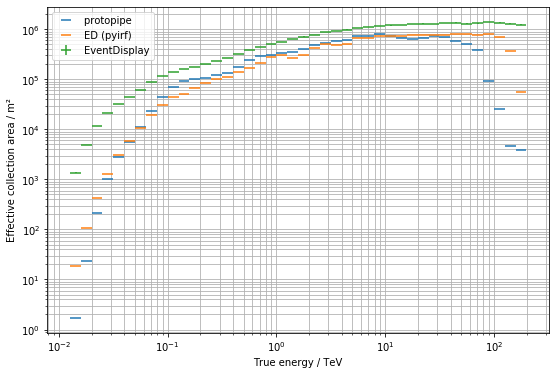

In [11]:
# protopipe
# uncomment the other strings to see effective areas
# for the different cut levels. Left out here for better
# visibility of the final effective areas.
suffixes = [
    ''
#     '_NO_CUTS',
#     '_ONLY_GH',
#     '_ONLY_THETA',
]

for suffix in suffixes: 
    area = QTable.read(protopipe_file, hdu='EFFECTIVE_AREA' + suffix)[0]
   
    plt.errorbar(
        0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1],
        area['EFFAREA'].to_value(u.m**2).T[1:-1, 0],
        xerr=0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label='protopipe ' + suffix,
    )

# ED (pyirf)
for suffix in suffixes: 
    area = QTable.read(ED_pyirf_file, hdu='EFFECTIVE_AREA' + suffix)[0]
   
    plt.errorbar(
        0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1],
        area['EFFAREA'].to_value(u.m**2).T[1:-1, 0],
        xerr=0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label='ED (pyirf) ' + suffix,
    )
    
# ED
(y, yerr), edges = irf_eventdisplay["EffectiveAreaEtrue"].to_numpy(errors=True)

x = bin_center(10**edges)
xerr = 0.5 * np.diff(10**edges)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="EventDisplay")

# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Effective collection area / m²")
plt.grid(which="both")
plt.legend()

None # to remove clutter by mpl objects

## Point Spread Function

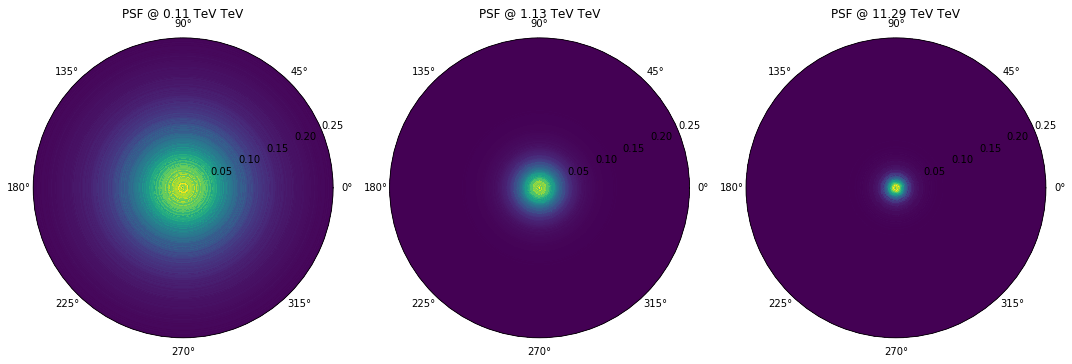

In [13]:
psf_table = QTable.read(protopipe_file, hdu='PSF')[0]
# select the only fov offset bin
psf = psf_table['RPSF'].T[:, 0, :].to_value(1 / u.sr)

offset_bins = np.append(psf_table['RAD_LO'], psf_table['RAD_HI'][-1])
phi_bins = np.linspace(0, 2 * np.pi, 100)



# Let's make a nice 2d representation of the radially symmetric PSF
r, phi = np.meshgrid(offset_bins.to_value(u.deg), phi_bins)

# look at a single energy bin
# repeat values for each phi bin
center = 0.5 * (psf_table['ENERG_LO'] + psf_table['ENERG_HI'])


fig = plt.figure(figsize=(15, 5))
axs = [fig.add_subplot(1, 3, i, projection='polar') for i in range(1, 4)]


for bin_id, ax in zip([10, 20, 30], axs):
    image = np.tile(psf[bin_id], (len(phi_bins) - 1, 1))
    
    ax.set_title(f'PSF @ {center[bin_id]:.2f} TeV')
    ax.pcolormesh(phi, r, image)
    ax.set_ylim(0, 0.25)
    ax.set_aspect(1)
    
fig.tight_layout()

None # to remove clutter by mpl objects


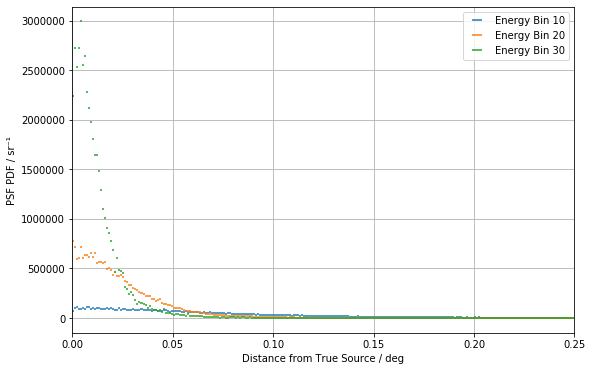

In [14]:
# Profile
center = 0.5 * (offset_bins[1:] + offset_bins[:-1])
xerr = 0.5 * (offset_bins[1:] - offset_bins[:-1])

for bin_id in [10, 20, 30]:
    plt.errorbar(
        center.to_value(u.deg),
        psf[bin_id],
        xerr=xerr.to_value(u.deg),
        ls='',
        label=f'Energy Bin {bin_id}'
    )
    
#plt.yscale('log')
plt.legend()
plt.xlim(0, 0.25)
plt.ylabel('PSF PDF / sr⁻¹')
plt.xlabel('Distance from True Source / deg')
plt.grid()

None # to remove clutter by mpl objects

### Angular resolution

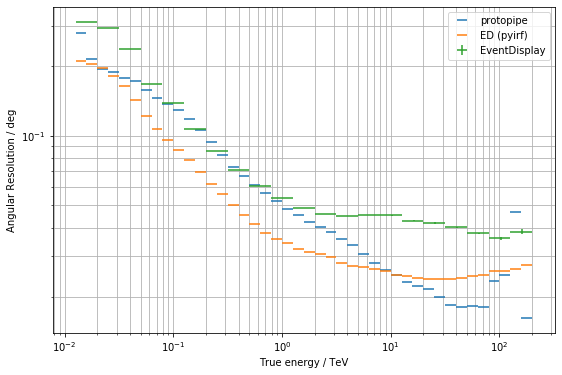

In [15]:
# protopipe
ang_res = QTable.read(protopipe_file, hdu='ANGULAR_RESOLUTION')[1:-1]

plt.errorbar(
    0.5 * (ang_res['true_energy_low'] + ang_res['true_energy_high']).to_value(u.TeV),
    ang_res['angular_resolution'].to_value(u.deg),
    xerr=0.5 * (ang_res['true_energy_high'] - ang_res['true_energy_low']).to_value(u.TeV),
    ls='',
    label='protopipe'
)

# ED (pyirf)
ang_res = QTable.read(ED_pyirf_file, hdu='ANGULAR_RESOLUTION')[1:-1]

plt.errorbar(
    0.5 * (ang_res['true_energy_low'] + ang_res['true_energy_high']).to_value(u.TeV),
    ang_res['angular_resolution'].to_value(u.deg),
    xerr=0.5 * (ang_res['true_energy_high'] - ang_res['true_energy_low']).to_value(u.TeV),
    ls='',
    label='ED (pyirf)'
)

# ED
(y, yerr), edges = irf_eventdisplay["AngRes"].to_numpy(errors=True)
x = bin_center(10**edges)
xerr = 0.5 * np.diff(10**edges)
plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="EventDisplay")

# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Angular Resolution / deg")
plt.grid(which="both")
plt.legend(loc="best")

None # to remove clutter by mpl objects

### Energy dispersion

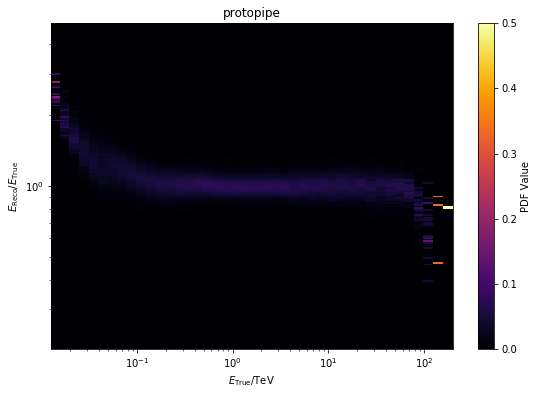

In [16]:
edisp = QTable.read(protopipe_file, hdu='ENERGY_DISPERSION')[0]

e_bins = edisp['ENERG_LO'][1:]
migra_bins = edisp['MIGRA_LO'][1:]

plt.title('protopipe')
plt.pcolormesh(e_bins.to_value(u.TeV), 
               migra_bins, 
               edisp['MATRIX'].T[1:-1, 1:-1, 0].T, 
               cmap='inferno',
               norm=LogNorm())

plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='PDF Value')

plt.xlabel(r'$E_\mathrm{True} / \mathrm{TeV}$')
plt.ylabel(r'$E_\mathrm{Reco} / E_\mathrm{True}$')

None # to remove clutter by mpl objects

### Energy resolution

In [ ]:
# protopipe
bias_resolution = QTable.read(protopipe_file, hdu='ENERGY_BIAS_RESOLUTION')[1:-1]
plt.errorbar(
    0.5 * (bias_resolution['true_energy_low'] + bias_resolution['true_energy_high']).to_value(u.TeV),
    bias_resolution['resolution'],
    xerr=0.5 * (bias_resolution['true_energy_high'] - bias_resolution['true_energy_low']).to_value(u.TeV),
    ls='',
    label='protopipe'
)
plt.xscale('log')

# ED (pyirf)
bias_resolution = QTable.read(ED_pyirf_file, hdu='ENERGY_BIAS_RESOLUTION')[1:-1]
plt.errorbar(
    0.5 * (bias_resolution['true_energy_low'] + bias_resolution['true_energy_high']).to_value(u.TeV),
    bias_resolution['resolution'],
    xerr=0.5 * (bias_resolution['true_energy_high'] - bias_resolution['true_energy_low']).to_value(u.TeV),
    ls='',
    label='ED (pyirf)'
)
plt.xscale('log')


# ED
(y, yerr), edges = irf_eventdisplay["ERes"].to_numpy(errors=True)
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2
plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="EventDisplay")

# Style settings
plt.xlabel(r"$E_\mathrm{True} / \mathrm{TeV}$")
plt.ylabel("Energy resolution")
plt.grid(which="both")
plt.legend(loc="best")

None # to remove clutter by mpl objects

## Background rate

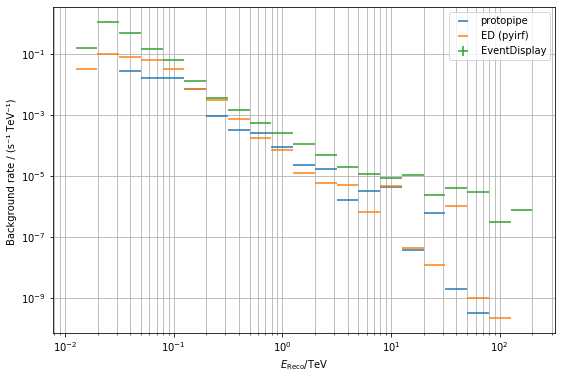

In [20]:
from pyirf.utils import cone_solid_angle

# protopipe
bg_rate = QTable.read(protopipe_file, hdu='BACKGROUND')[0]

reco_bins = np.append(bg_rate['ENERG_LO'], bg_rate['ENERG_HI'][-1])

# first fov bin, [0, 1] deg
fov_bin = 0
rate_bin = bg_rate['BKG'].T[:, fov_bin]

# interpolate theta cut for given e reco bin
e_center_bg = 0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI'])
e_center_theta = 0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])
theta_cut = np.interp(e_center_bg, e_center_theta, rad_max['RAD_MAX'].T[:, 0])

# undo normalization
rate_bin *= cone_solid_angle(theta_cut)
rate_bin *= np.diff(reco_bins)
plt.errorbar(
    0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI']).to_value(u.TeV)[1:-1],
    rate_bin.to_value(1 / u.s)[1:-1],
    xerr=np.diff(reco_bins).to_value(u.TeV)[1:-1] / 2,
    ls='',
    label='protopipe',
)

# ED (pyirf)
bg_rate = QTable.read(ED_pyirf_file, hdu='BACKGROUND')[0]

reco_bins = np.append(bg_rate['ENERG_LO'], bg_rate['ENERG_HI'][-1])

# first fov bin, [0, 1] deg
fov_bin = 0
rate_bin = bg_rate['BKG'].T[:, fov_bin]

# interpolate theta cut for given e reco bin
e_center_bg = 0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI'])
e_center_theta = 0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])
theta_cut = np.interp(e_center_bg, e_center_theta, rad_max['RAD_MAX'].T[:, 0])

# undo normalization
rate_bin *= cone_solid_angle(theta_cut)
rate_bin *= np.diff(reco_bins)
plt.errorbar(
    0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI']).to_value(u.TeV)[1:-1],
    rate_bin.to_value(1 / u.s)[1:-1],
    xerr=np.diff(reco_bins).to_value(u.TeV)[1:-1] / 2,
    ls='',
    label='ED (pyirf)',
)

# ED
(y, yerr), edges = irf_eventdisplay["BGRate"].to_numpy(errors=True)
x = bin_center(10**edges)
xerr = np.diff(10**edges) / 2
plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="EventDisplay")

# Style settings
plt.xscale("log")
plt.xlabel(r"$E_\mathrm{Reco} / \mathrm{TeV}$")
plt.ylabel("Background rate / (s⁻¹ TeV⁻¹) ")
plt.grid(which="both")
plt.legend(loc="best")
plt.yscale('log')

None # to remove clutter by mpl objects